In [1]:
import pandas as pd

from tms_risk.utils import get_subjects, get_tms_conditions
from tqdm.contrib.itertools import product
import seaborn as sns
import pingouin
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

bids_folder  = '/data/ds-tmsrisk'

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

# Only TMS cluster

In [2]:
subjects = get_subjects(all_tms_conditions=True)

In [3]:
pars = []
keys = []

for sub, session, roi in product(subjects, [1,2,3], ['NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/105 [00:00<?, ?it/s]

In [4]:
pars_ = pars.copy()

* Find distribution of mus
* Find amplitudes as function of mus
* Find R2 as a function of mus

# Use only pars with CVr > 0.0 _within session_ and then see effect of brain sitmulation

In [82]:
thr_pars = pars[pars.cvr2 > 0.0]

tmp = thr_pars.groupby(['subject', 'stimulation_condition']).mean().stack().to_frame('value')

In [85]:
tmp2.reset_index()

,subject,stimulation_condition,parameter,value
0,01,ips,amplitude,1.386455
1,01,vertex,amplitude,2.029330
2,02,ips,amplitude,1.474647
3,02,vertex,amplitude,0.523121
4,03,ips,amplitude,0.600250
...,...,...,...,...
64,69,vertex,amplitude,0.950151
65,72,ips,amplitude,0.658301
66,72,vertex,amplitude,0.725185
67,74,ips,amplitude,1.243276


In [86]:
pingouin.pairwise_tests

<function pingouin.pairwise.pairwise_tests(data=None, dv=None, between=None, within=None, subject=None, parametric=True, marginal=True, alpha=0.05, alternative='two-sided', padjust='none', effsize='hedges', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)>

In [97]:
thr_pars.index.unique(level='subject').

(35,)

In [90]:
from IPython.display import display

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-2.706309,33.0,two-sided,0.010686,4.08,-0.493735


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-1.018642,33.0,two-sided,0.315783,0.296,-0.253753


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-0.562091,33.0,two-sided,0.577852,0.213,-0.117756


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,1.321954,33.0,two-sided,0.195274,0.407,0.28848


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-0.820605,33.0,two-sided,0.41776,0.251,-0.144481


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,0.382384,33.0,two-sided,0.704628,0.197,0.081707


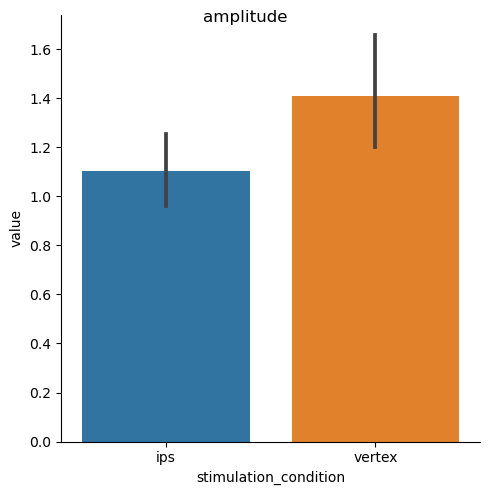

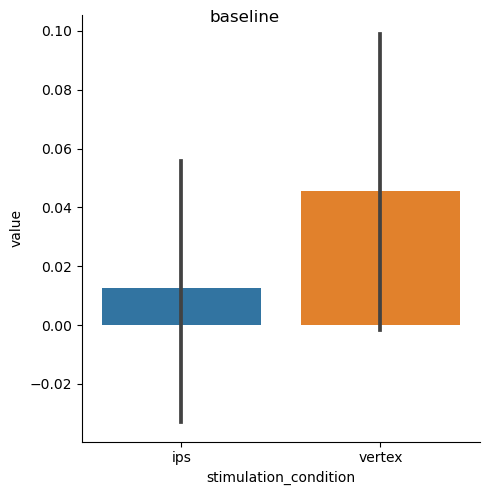

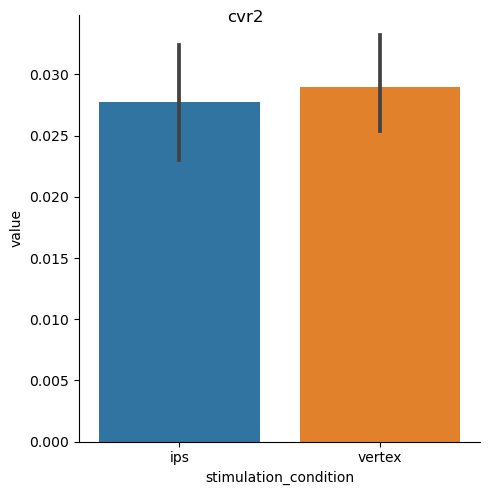

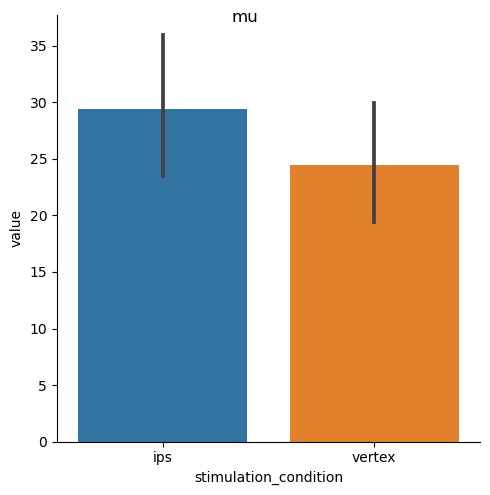

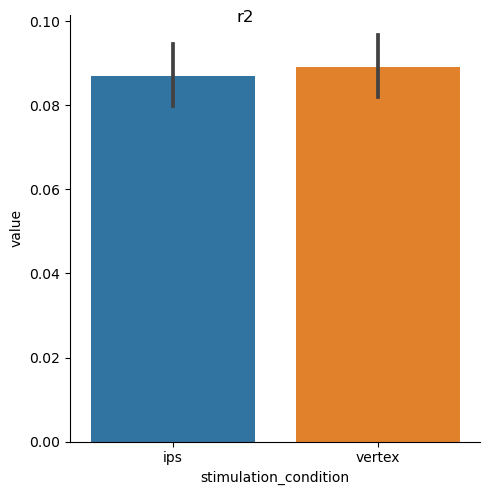

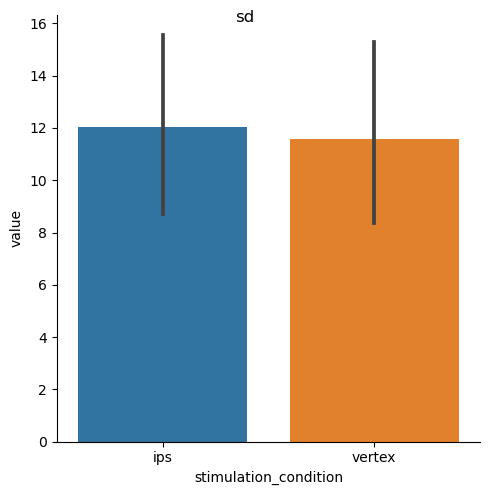

In [92]:
for par, tmp2 in tmp.drop('baseline', level='stimulation_condition').groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    # print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))
    display(pingouin.pairwise_tests(data=tmp2.reset_index(), dv='value', within='stimulation_condition', subject='subject'))

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,3.019308,0.09133,0.028887,1.0


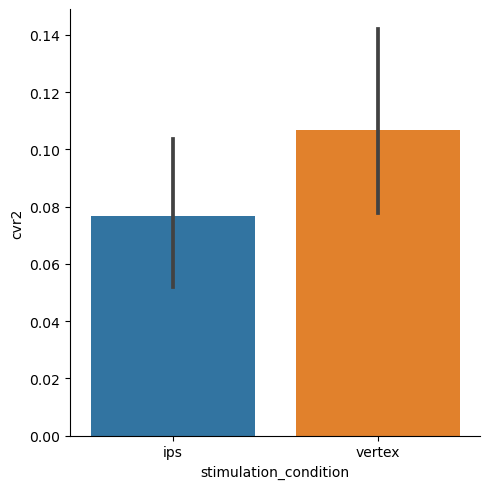

In [75]:
tmp = (pars['cvr2'] > 0.0).drop('baseline', level='stimulation_condition').groupby(['subject', 'stimulation_condition']).mean().reset_index()

sns.catplot(x='stimulation_condition', y='cvr2', data=tmp.reset_index(), kind='bar')

pingouin.rm_anova(tmp, 'cvr2', 'stimulation_condition', 'subject')

                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.746469  0.393651  0.011242  1.0
                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.698493  0.409126  0.005804  1.0
                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.000137  0.990738  0.000001  1.0
                  Source  ddof1  ddof2         F    p-unc       ng2  eps
0  stimulation_condition      1     34  2.239858  0.14372  0.020081  1.0
                  Source  ddof1  ddof2         F     p-unc     ng2  eps
0  stimulation_condition      1     34  3.907283  0.056234  0.0143  1.0
                  Source  ddof1  ddof2        F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.04187  0.839088  0.000635  1.0


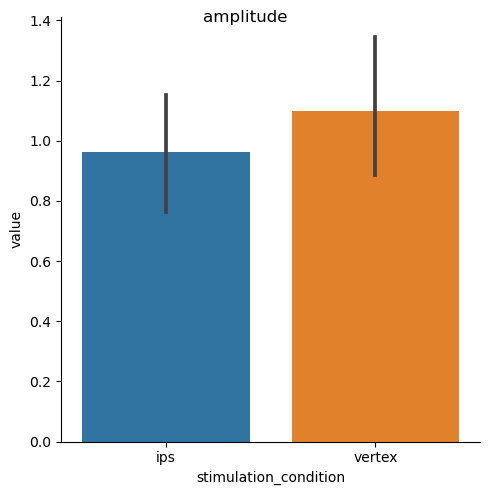

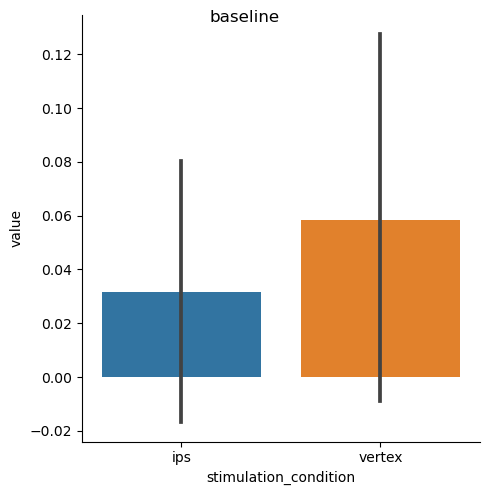

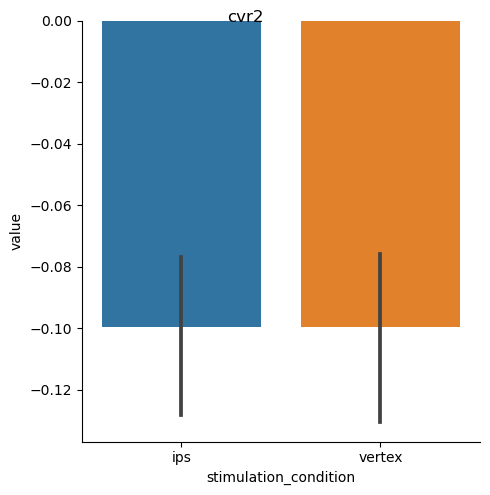

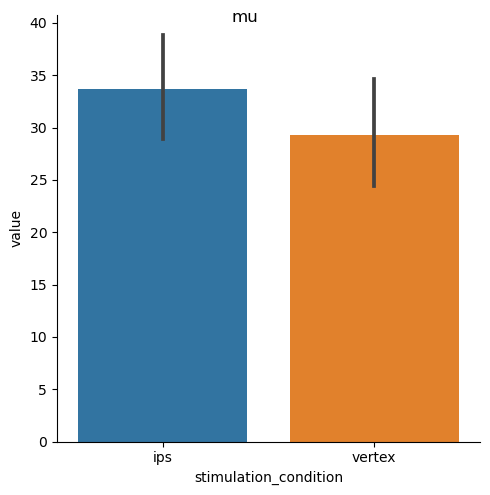

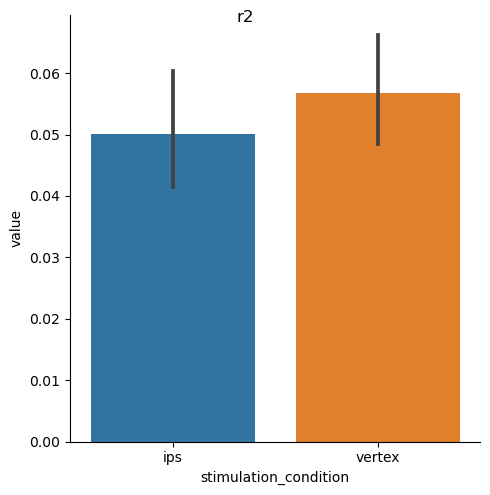

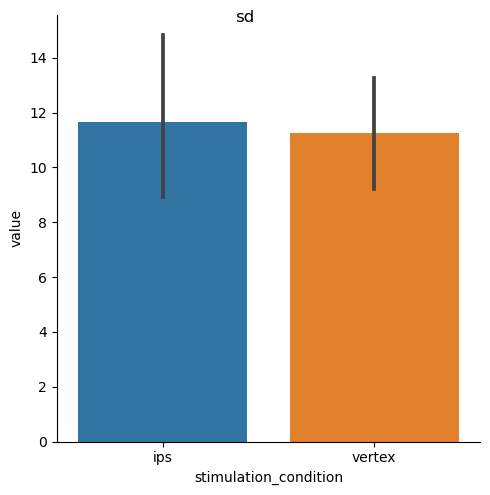

In [69]:
for par, tmp2 in tmp.drop('baseline', level='stimulation_condition').groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))

# All ROIs

In [98]:
pars = []
keys = []

for sub, session, roi in product(subjects[:2], [2,3], ['NPCl', 'NPCr', 'NTOl', 'NTOr', 'NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/30 [00:00<?, ?it/s]

In [103]:
thr_pars = pars[pars.cvr2 > 0.0]

tmp = thr_pars.groupby(['subject', 'stimulation_condition', 'roi']).mean().stack().to_frame('value')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,1.651398,1.0,two-sided,0.346632,0.939,0.369778


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-0.687054,1.0,two-sided,0.616765,0.635,-0.409865


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-3.01901,1.0,two-sided,0.203629,1.303,-0.636236


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,1.886061,1.0,two-sided,0.310364,1.01,0.916666


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,0.073189,1.0,two-sided,0.953489,0.525,0.041643


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,0.784664,1.0,two-sided,0.576444,0.663,0.61363


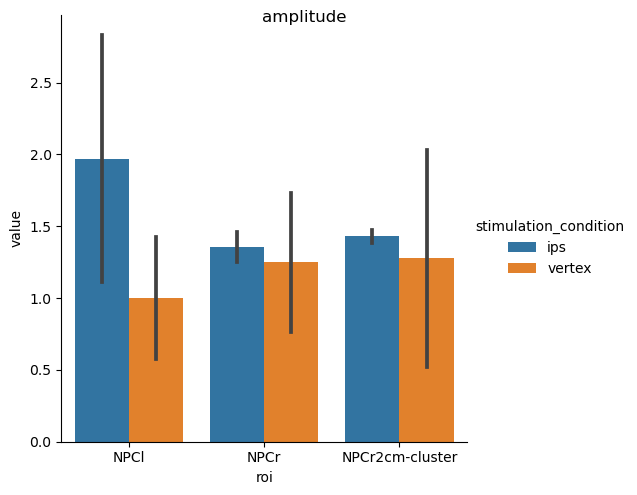

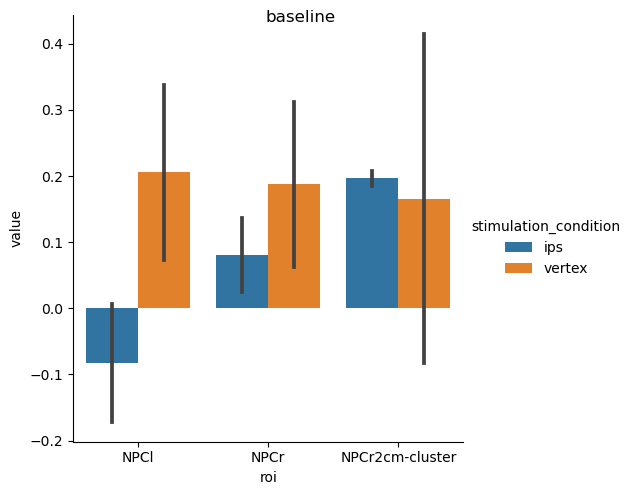

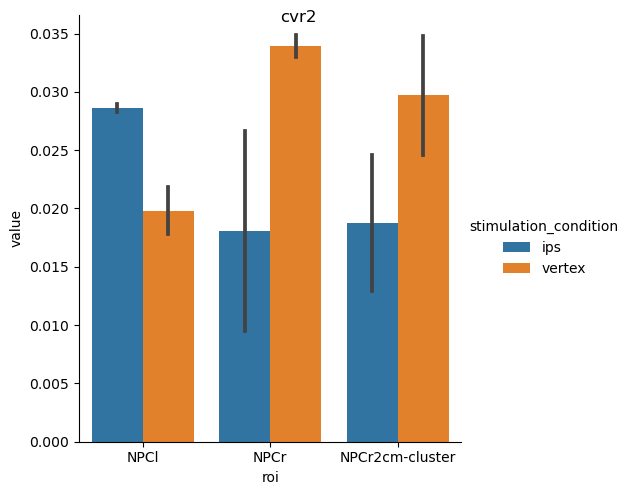

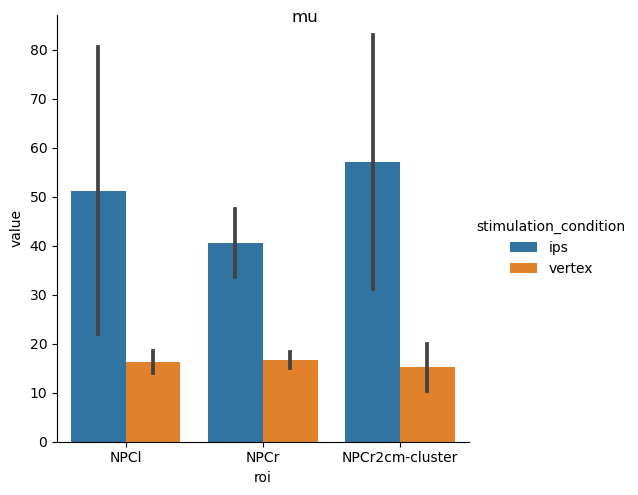

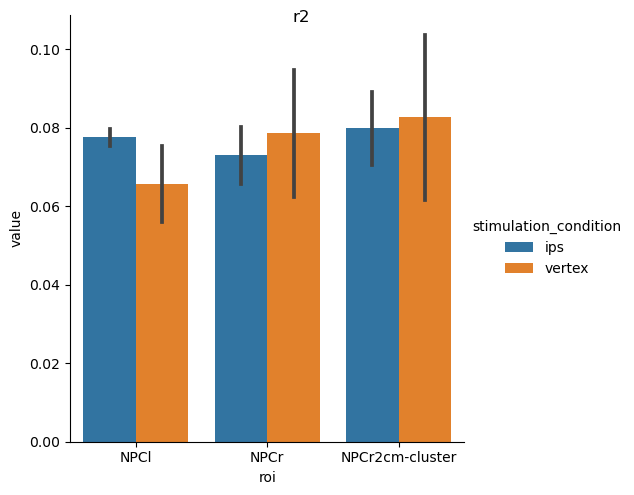

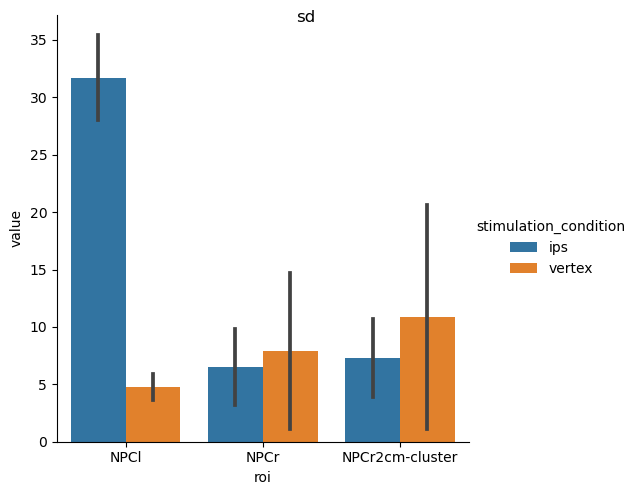

In [104]:
for par, tmp2 in tmp.drop('baseline', level='stimulation_condition').groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='roi', hue='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    # print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))
    display(pingouin.pairwise_tests(data=tmp2.reset_index(), dv='value', within='stimulation_condition', subject='subject'))